# Machine learning for titer prediction
The proteomics data we have for isoprenol titer is extremely underutilized - I'd like to do some ML on it to see if we can learn anything about predicting titer, or about biological correlations between proteins. 

I'm still trying to identify potential questions to answer.

In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Import data

I've already pulled data from EDD, normalized it, and merged it.

In [44]:
data_file = './data/normalized_proteomics_pivot.csv'
omics = pd.read_csv(data_file, index_col=0)
omics

,MM_1762,PP_0001,PP_0002,PP_0003,PP_0004,PP_0005,PP_0006,PP_0009,PP_0010,PP_0011,...,PP_5416,PP_5417,PP_5418,SPy_1046,YNR043W,aacC1,b4055 JW4015,mvaS,neo,isoprenol
line_name_rep_cycle,,,,,,,,,,,,,,,,,,,,,
Control-R10_c1,0.951793,1.094915,0.970530,1.133319,0.957359,0.787047,0.934429,1.095724,1.152434,0.898198,...,0.792854,0.952586,0.000000,1.275427,0.988950,1.042664,1.075991,0.995796,1.110129,1.024392
Control-R11_c1,1.047312,0.771961,0.854275,1.007493,0.911182,0.794843,1.079606,1.054531,1.054544,1.061720,...,0.872016,1.053211,0.022315,1.095618,1.066124,1.094487,1.224033,1.056521,1.058979,1.120367
Control-R12_c1,1.054954,1.242484,0.500928,1.154855,0.969491,1.662368,0.994657,0.958415,0.958498,1.031600,...,0.890724,0.955814,6.881715,1.179865,1.025106,1.093481,0.905480,1.047002,1.131022,1.178920
Control-R13_c1,0.933705,1.051552,1.586093,0.932927,0.992892,0.994851,1.013185,1.252256,1.137690,1.056214,...,1.008304,1.037332,0.021247,0.819190,1.014700,0.950900,0.904057,0.931308,0.896219,0.720284
Control-R14_c1,0.920443,1.294411,1.084229,1.028170,0.825054,0.875014,1.036462,1.172617,0.838294,1.033187,...,0.991993,0.899485,0.045492,0.901863,1.047413,0.883845,0.997991,0.853035,1.083941,1.030501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PP_5419-R2_c1,0.831806,1.079450,0.040345,0.591196,0.433515,1.591181,0.635789,0.521773,0.651952,0.840361,...,0.630470,0.871891,0.028549,0.036465,0.972795,0.033226,1.222933,1.042099,1.008801,2.153361
PP_5419-R3_c1,0.854970,1.111790,0.310904,0.663168,0.667366,2.381747,0.622027,0.634366,1.168989,0.809204,...,0.596430,0.767842,0.029056,0.037112,0.938466,0.009552,1.087679,1.080355,1.079077,2.397354
PP_5420-R1_c1,1.004817,1.104894,0.442635,0.748915,0.337878,1.798357,0.237874,0.392700,0.869069,0.328949,...,0.726382,0.892056,0.084788,0.030160,0.705855,0.000445,0.730318,0.143453,1.447907,0.484521


### Drop any lines with missing isoprenol measurements

In [45]:
omics = omics.dropna(axis = 0, how = 'any', subset=['isoprenol'])
omics

,MM_1762,PP_0001,PP_0002,PP_0003,PP_0004,PP_0005,PP_0006,PP_0009,PP_0010,PP_0011,...,PP_5416,PP_5417,PP_5418,SPy_1046,YNR043W,aacC1,b4055 JW4015,mvaS,neo,isoprenol
line_name_rep_cycle,,,,,,,,,,,,,,,,,,,,,
Control-R10_c1,0.951793,1.094915,0.970530,1.133319,0.957359,0.787047,0.934429,1.095724,1.152434,0.898198,...,0.792854,0.952586,0.000000,1.275427,0.988950,1.042664,1.075991,0.995796,1.110129,1.024392
Control-R11_c1,1.047312,0.771961,0.854275,1.007493,0.911182,0.794843,1.079606,1.054531,1.054544,1.061720,...,0.872016,1.053211,0.022315,1.095618,1.066124,1.094487,1.224033,1.056521,1.058979,1.120367
Control-R12_c1,1.054954,1.242484,0.500928,1.154855,0.969491,1.662368,0.994657,0.958415,0.958498,1.031600,...,0.890724,0.955814,6.881715,1.179865,1.025106,1.093481,0.905480,1.047002,1.131022,1.178920
Control-R13_c1,0.933705,1.051552,1.586093,0.932927,0.992892,0.994851,1.013185,1.252256,1.137690,1.056214,...,1.008304,1.037332,0.021247,0.819190,1.014700,0.950900,0.904057,0.931308,0.896219,0.720284
Control-R14_c1,0.920443,1.294411,1.084229,1.028170,0.825054,0.875014,1.036462,1.172617,0.838294,1.033187,...,0.991993,0.899485,0.045492,0.901863,1.047413,0.883845,0.997991,0.853035,1.083941,1.030501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PP_5419-R2_c1,0.831806,1.079450,0.040345,0.591196,0.433515,1.591181,0.635789,0.521773,0.651952,0.840361,...,0.630470,0.871891,0.028549,0.036465,0.972795,0.033226,1.222933,1.042099,1.008801,2.153361
PP_5419-R3_c1,0.854970,1.111790,0.310904,0.663168,0.667366,2.381747,0.622027,0.634366,1.168989,0.809204,...,0.596430,0.767842,0.029056,0.037112,0.938466,0.009552,1.087679,1.080355,1.079077,2.397354
PP_5420-R1_c1,1.004817,1.104894,0.442635,0.748915,0.337878,1.798357,0.237874,0.392700,0.869069,0.328949,...,0.726382,0.892056,0.084788,0.030160,0.705855,0.000445,0.730318,0.143453,1.447907,0.484521


### Drop any columns with any missing values

In [46]:
omics = omics.dropna(axis = 1, how = 'any')
omics

,MM_1762,PP_0001,PP_0002,PP_0003,PP_0004,PP_0005,PP_0006,PP_0009,PP_0010,PP_0011,...,PP_5416,PP_5417,PP_5418,SPy_1046,YNR043W,aacC1,b4055 JW4015,mvaS,neo,isoprenol
line_name_rep_cycle,,,,,,,,,,,,,,,,,,,,,
Control-R10_c1,0.951793,1.094915,0.970530,1.133319,0.957359,0.787047,0.934429,1.095724,1.152434,0.898198,...,0.792854,0.952586,0.000000,1.275427,0.988950,1.042664,1.075991,0.995796,1.110129,1.024392
Control-R11_c1,1.047312,0.771961,0.854275,1.007493,0.911182,0.794843,1.079606,1.054531,1.054544,1.061720,...,0.872016,1.053211,0.022315,1.095618,1.066124,1.094487,1.224033,1.056521,1.058979,1.120367
Control-R12_c1,1.054954,1.242484,0.500928,1.154855,0.969491,1.662368,0.994657,0.958415,0.958498,1.031600,...,0.890724,0.955814,6.881715,1.179865,1.025106,1.093481,0.905480,1.047002,1.131022,1.178920
Control-R13_c1,0.933705,1.051552,1.586093,0.932927,0.992892,0.994851,1.013185,1.252256,1.137690,1.056214,...,1.008304,1.037332,0.021247,0.819190,1.014700,0.950900,0.904057,0.931308,0.896219,0.720284
Control-R14_c1,0.920443,1.294411,1.084229,1.028170,0.825054,0.875014,1.036462,1.172617,0.838294,1.033187,...,0.991993,0.899485,0.045492,0.901863,1.047413,0.883845,0.997991,0.853035,1.083941,1.030501
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PP_5419-R2_c1,0.831806,1.079450,0.040345,0.591196,0.433515,1.591181,0.635789,0.521773,0.651952,0.840361,...,0.630470,0.871891,0.028549,0.036465,0.972795,0.033226,1.222933,1.042099,1.008801,2.153361
PP_5419-R3_c1,0.854970,1.111790,0.310904,0.663168,0.667366,2.381747,0.622027,0.634366,1.168989,0.809204,...,0.596430,0.767842,0.029056,0.037112,0.938466,0.009552,1.087679,1.080355,1.079077,2.397354
PP_5420-R1_c1,1.004817,1.104894,0.442635,0.748915,0.337878,1.798357,0.237874,0.392700,0.869069,0.328949,...,0.726382,0.892056,0.084788,0.030160,0.705855,0.000445,0.730318,0.143453,1.447907,0.484521


In [56]:
omics.isnull().sum().sum()

0

In [53]:
omics.isna().sum().sum()

0

In [50]:
np.where(omics.isna())

(array([], dtype=int64), array([], dtype=int64))

In [5]:
omics.to_csv('./data/normalized_proteomics_pivot_cleaned.csv')

### get a list of protein measurements
The protein measurements are every column except the last one

In [6]:
protein_measurements = omics.columns[:-1]
protein_measurements

Index(['MM_1762', 'PP_0001', 'PP_0002', 'PP_0003', 'PP_0004', 'PP_0005',
       'PP_0006', 'PP_0009', 'PP_0010', 'PP_0011',
       ...
       'PP_5415', 'PP_5416', 'PP_5417', 'PP_5418', 'SPy_1046', 'YNR043W',
       'aacC1', 'b4055 JW4015', 'mvaS', 'neo'],
      dtype='object', length=1898)

### Define X and y for ML

In [22]:
X = omics[protein_measurements]
y = omics['isoprenol']
X

,MM_1762,PP_0001,PP_0002,PP_0003,PP_0004,PP_0005,PP_0006,PP_0009,PP_0010,PP_0011,...,PP_5415,PP_5416,PP_5417,PP_5418,SPy_1046,YNR043W,aacC1,b4055 JW4015,mvaS,neo
line_name_rep_cycle,,,,,,,,,,,,,,,,,,,,,
Control-R10_c1,0.951793,1.094915,0.970530,1.133319,0.957359,0.787047,0.934429,1.095724,1.152434,0.898198,...,0.951346,0.792854,0.952586,0.000000,1.275427,0.988950,1.042664,1.075991,0.995796,1.110129
Control-R11_c1,1.047312,0.771961,0.854275,1.007493,0.911182,0.794843,1.079606,1.054531,1.054544,1.061720,...,0.988927,0.872016,1.053211,0.022315,1.095618,1.066124,1.094487,1.224033,1.056521,1.058979
Control-R12_c1,1.054954,1.242484,0.500928,1.154855,0.969491,1.662368,0.994657,0.958415,0.958498,1.031600,...,1.031219,0.890724,0.955814,6.881715,1.179865,1.025106,1.093481,0.905480,1.047002,1.131022
Control-R13_c1,0.933705,1.051552,1.586093,0.932927,0.992892,0.994851,1.013185,1.252256,1.137690,1.056214,...,1.072695,1.008304,1.037332,0.021247,0.819190,1.014700,0.950900,0.904057,0.931308,0.896219
Control-R14_c1,0.920443,1.294411,1.084229,1.028170,0.825054,0.875014,1.036462,1.172617,0.838294,1.033187,...,0.991063,0.991993,0.899485,0.045492,0.901863,1.047413,0.883845,0.997991,0.853035,1.083941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PP_5419-R2_c1,0.831806,1.079450,0.040345,0.591196,0.433515,1.591181,0.635789,0.521773,0.651952,0.840361,...,0.742051,0.630470,0.871891,0.028549,0.036465,0.972795,0.033226,1.222933,1.042099,1.008801
PP_5419-R3_c1,0.854970,1.111790,0.310904,0.663168,0.667366,2.381747,0.622027,0.634366,1.168989,0.809204,...,0.756146,0.596430,0.767842,0.029056,0.037112,0.938466,0.009552,1.087679,1.080355,1.079077
PP_5420-R1_c1,1.004817,1.104894,0.442635,0.748915,0.337878,1.798357,0.237874,0.392700,0.869069,0.328949,...,0.645999,0.726382,0.892056,0.084788,0.030160,0.705855,0.000445,0.730318,0.143453,1.447907


In [23]:
X.columns[-10:]

Index(['PP_5415', 'PP_5416', 'PP_5417', 'PP_5418', 'SPy_1046', 'YNR043W',
       'aacC1', 'b4055 JW4015', 'mvaS', 'neo'],
      dtype='object')

In [24]:
dcas9 = X['SPy_1046'].copy()

In [7]:
y

line_name_rep_cycle
Control-R10_c1    1.024392
Control-R11_c1    1.120367
Control-R12_c1    1.178920
Control-R13_c1    0.720284
Control-R14_c1    1.030501
                    ...   
PP_5419-R2_c1     2.153361
PP_5419-R3_c1     2.397354
PP_5420-R1_c1     0.484521
PP_5420-R2_c1     0.527125
PP_5420-R3_c1     0.556424
Name: isoprenol, Length: 954, dtype: float64

### Get X and y for dCas9 prediction
Drop the dCas9 column from X and make it a separate target.

In [25]:
dcas9_column_name = 'SPy_1046'
X_dcas9 = omics.copy().drop(columns=dcas9_column_name)
y_dcas9 = X[dcas9_column_name].copy()

### Get convenience values
Get number of gRNA, cycle, and whether or not the line is a control based on the dataframe index (the line name)

In [8]:
omics_index = omics.index.values
cycle_label = [int(x[-1]) for x in omics_index]
num_grna = [x.count('PP') for x in omics_index]
is_control = [1 if 'ontrol' in x else 0 for x in omics_index]

### Scale data for ML

In [26]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)
X_norm
X_norm_df = X.copy()
X_norm_df.iloc[:,:] = X_norm
X_norm_df

X_dcas9_norm = scaler.fit_transform(X_dcas9)
X_dcas9_norm_df = X_dcas9.copy()
X_dcas9_norm_df.iloc[:,:] = X_dcas9_norm
X_dcas9_norm_df

,MM_1762,PP_0001,PP_0002,PP_0003,PP_0004,PP_0005,PP_0006,PP_0009,PP_0010,PP_0011,...,PP_5415,PP_5416,PP_5417,PP_5418,YNR043W,aacC1,b4055 JW4015,mvaS,neo,isoprenol
line_name_rep_cycle,,,,,,,,,,,,,,,,,,,,,
Control-R10_c1,-0.178359,0.333337,0.236442,0.730201,0.214045,-0.615200,0.120286,0.449077,0.585448,0.055800,...,-0.370637,-0.812213,-0.418893,-0.723273,-0.137959,0.183642,0.092831,-0.242776,0.502197,-0.626291
Control-R11_c1,0.256741,-0.632415,-0.043863,0.323814,0.077110,-0.599166,0.875926,0.357660,0.286140,0.605347,...,-0.158547,-0.542567,0.159480,-0.706700,0.202912,0.323659,0.528318,-0.128438,0.302209,-0.476732
Control-R12_c1,0.291552,0.774624,-0.895827,0.799757,0.250024,1.185086,0.433766,0.144353,-0.007532,0.504123,...,0.080137,-0.478841,-0.400341,4.387655,0.021738,0.320941,-0.408752,-0.146362,0.583885,-0.385489
Control-R13_c1,-0.260755,0.203667,1.720643,0.082983,0.319418,-0.187807,0.530207,0.796462,0.540367,0.586844,...,0.314210,-0.078330,0.068212,-0.707493,-0.024224,-0.064290,-0.412936,-0.364200,-0.334143,-1.100183
Control-R14_c1,-0.321165,0.929906,0.510587,0.390596,-0.178299,-0.434278,0.651360,0.619722,-0.375069,0.509455,...,-0.146493,-0.133890,-0.724109,-0.689487,0.120269,-0.245462,-0.136616,-0.511579,0.399807,-0.616770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PP_5419-R2_c1,-0.724915,0.287091,-2.006352,-1.020731,-1.339394,1.038674,-1.434123,-0.824668,-0.944827,-0.138570,...,-1.551816,-1.365337,-0.882716,-0.702070,-0.209314,-2.543702,0.525083,-0.155594,0.106028,1.132990
PP_5419-R3_c1,-0.619403,0.383800,-1.354000,-0.788276,-0.645917,2.664641,-1.505755,-0.574795,0.636068,-0.243281,...,-1.472269,-1.481285,-1.480765,-0.701694,-0.360942,-2.607665,0.127214,-0.083562,0.380789,1.513205
PP_5420-R1_c1,0.063173,0.363178,-1.036380,-0.511335,-1.623002,1.464776,-3.505256,-1.111117,-0.280969,-1.857264,...,-2.093896,-1.038634,-0.766809,-0.660302,-1.388371,-2.632270,-0.924016,-1.847640,1.822833,-1.467575


## "Machine learning"
Want to try some basic sklearn on the data.

### PCA
See how well PCA can fit the data (how many components required) and whether PCA shows any obvious patterns with titer.

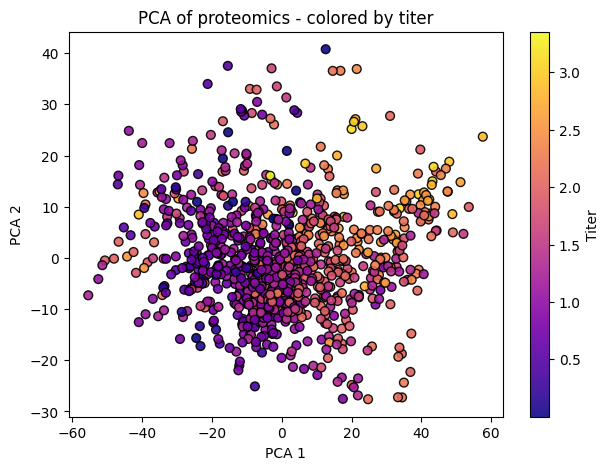

In [28]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 10)
X_pca = pca.fit_transform(X_norm)
fig, ax = plt.subplots(figsize = (7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c = y, s = 40, alpha = 0.9, edgecolors='k', cmap = 'plasma')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
cbar = plt.colorbar(label = 'Titer')
# cbar.ax.set_ylabel('Titer')

plt.title('PCA of proteomics - colored by titer')
fig.savefig('./figures/PCA_colored_by_titer.png')

Text(0.5, 1.0, 'PCA of proteomics - colored by titer')

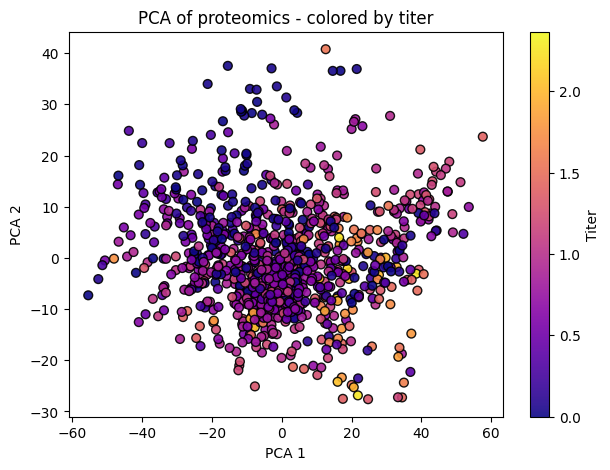

In [29]:
pca = PCA(n_components = 10)
X_pca_dcas9 = pca.fit_transform(X_dcas9_norm)
fig, ax = plt.subplots(figsize = (7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c = y_dcas9, s = 40, alpha = 0.9, edgecolors='k', cmap = 'plasma')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
cbar = plt.colorbar(label = 'Titer')
# cbar.ax.set_ylabel('Titer')

plt.title('PCA of proteomics - colored by titer')

In [11]:
X_pca.shape

(954, 10)

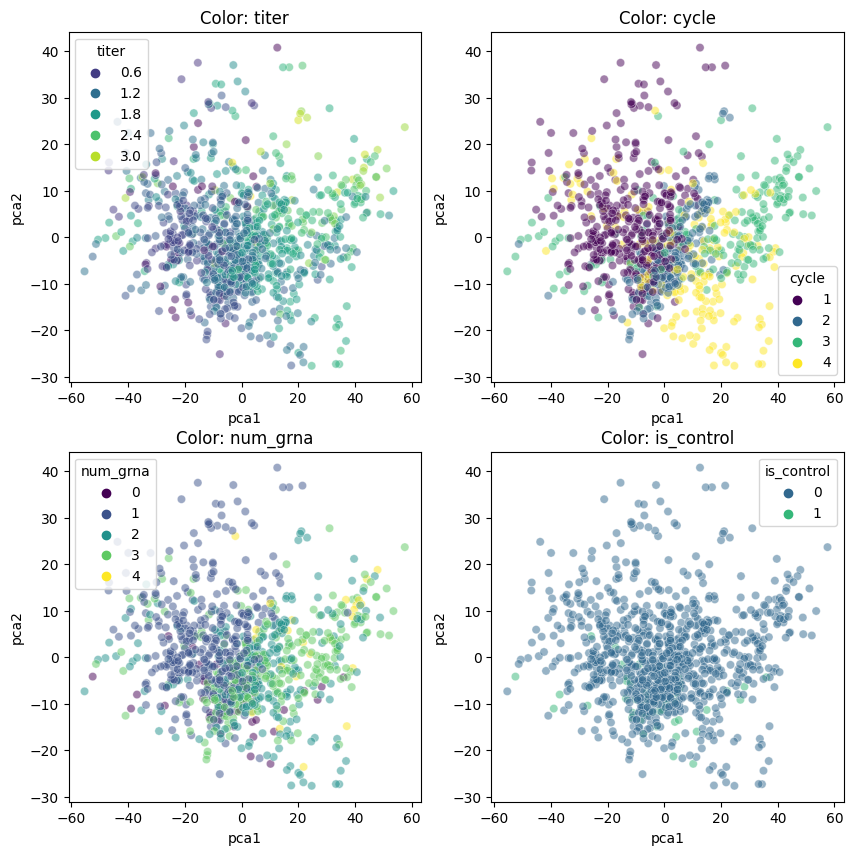

In [12]:
fig, ax = plt.subplots(nrows=2, ncols = 2, figsize = (10,10))
df_plot = pd.DataFrame(dict(pca1 = X_pca[:,0], pca2 = X_pca[:, 1], titer = y, cycle = cycle_label, num_grna = num_grna, is_control = is_control))

c_lbls = ['titer', 'cycle', 'num_grna', 'is_control']
for idx, axis in enumerate(fig.get_axes()):
    sns.scatterplot(df_plot, x = 'pca1', y = 'pca2', hue = c_lbls[idx], palette = 'viridis', ax = axis, alpha = 0.5)
    axis.set_title(f'Color: {c_lbls[idx]}')
    

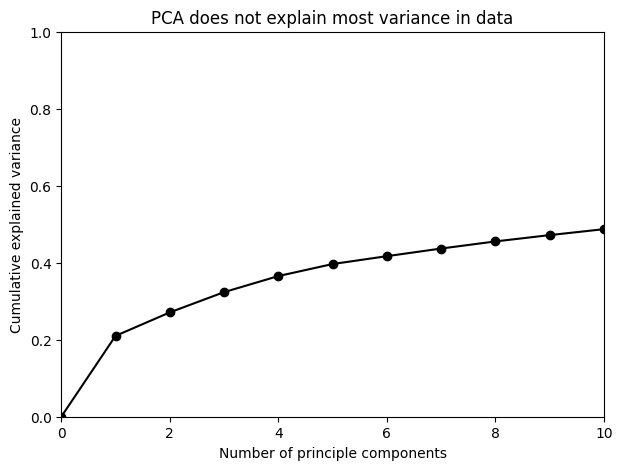

In [13]:
fig, ax = plt.subplots(figsize = (7,5))
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
ax.plot(np.arange(0, pca.n_components+1), np.concatenate((np.array([0]), cumulative_variance)), c = 'k', marker = 'o')
ax.set_ylim([0,1])
ax.set_xlim([0, 10])
ax.set_xlabel('Number of principle components')
ax.set_ylabel('Cumulative explained variance')
ax.set_title('PCA does not explain most variance in data')
fig.savefig('./figures/PCA_var_exp.png')

### Exploring differences between cycles
PCA shows that the first PCA dimension fully separates the two cycles. What variables are most associated with PC1?

In [14]:
weights = pca.components_
weights.shape

(10, 1898)

In [15]:
weights_df = pd.DataFrame(dict(ft = protein_measurements, pca1 = weights[0,:], pca2 = weights[1,:]))
weights_df

,ft,pca1,pca2
0,MM_1762,0.021387,-0.009567
1,PP_0001,0.020522,-0.019417
2,PP_0002,0.018560,-0.026803
3,PP_0003,0.032507,-0.019704
4,PP_0004,0.018670,-0.011807
...,...,...,...
1893,YNR043W,0.012260,-0.007870
1894,aacC1,0.007198,-0.051323
1895,b4055 JW4015,0.018486,0.005104
1896,mvaS,0.022453,-0.005886


<Axes: xlabel='pca1', ylabel='pca2'>

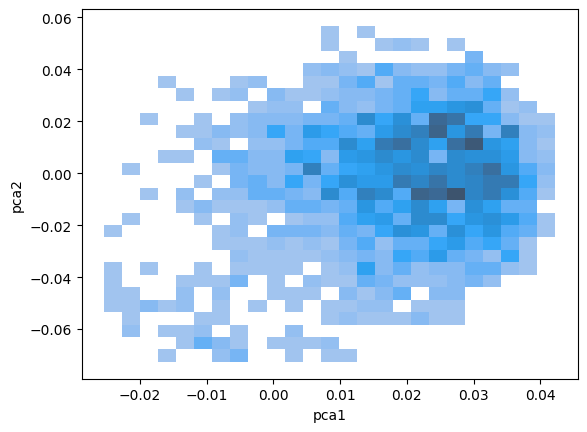

In [16]:
sns.histplot(weights_df, x = 'pca1', y = 'pca2')

identify top 10 PC1 components

In [17]:
top_10_pc1 = weights_df.sort_values(by='pca1', ascending = False)['ft'].head(10)
top_10_pc1

1035    PP_2488
1332    PP_4200
323     PP_0759
750     PP_1702
1258    PP_3922
1685    PP_4998
688     PP_1529
1829    PP_5283
30      PP_0072
1513    PP_4684
Name: ft, dtype: object

In [18]:
top_10_pc1.iloc[0]

'PP_2488'

In [19]:
X_norm_df

,MM_1762,PP_0001,PP_0002,PP_0003,PP_0004,PP_0005,PP_0006,PP_0009,PP_0010,PP_0011,...,PP_5415,PP_5416,PP_5417,PP_5418,SPy_1046,YNR043W,aacC1,b4055 JW4015,mvaS,neo
line_name_rep_cycle,,,,,,,,,,,,,,,,,,,,,
Control-R10_c1,-0.178359,0.333337,0.236442,0.730201,0.214045,-0.615200,0.120286,0.449077,0.585448,0.055800,...,-0.370637,-0.812213,-0.418893,-0.723273,1.086208,-0.137959,0.183642,0.092831,-0.242776,0.502197
Control-R11_c1,0.256741,-0.632415,-0.043863,0.323814,0.077110,-0.599166,0.875926,0.357660,0.286140,0.605347,...,-0.158547,-0.542567,0.159480,-0.706700,0.720845,0.202912,0.323659,0.528318,-0.128438,0.302209
Control-R12_c1,0.291552,0.774624,-0.895827,0.799757,0.250024,1.185086,0.433766,0.144353,-0.007532,0.504123,...,0.080137,-0.478841,-0.400341,4.387655,0.892032,0.021738,0.320941,-0.408752,-0.146362,0.583885
Control-R13_c1,-0.260755,0.203667,1.720643,0.082983,0.319418,-0.187807,0.530207,0.796462,0.540367,0.586844,...,0.314210,-0.078330,0.068212,-0.707493,0.159158,-0.024224,-0.064290,-0.412936,-0.364200,-0.334143
Control-R14_c1,-0.321165,0.929906,0.510587,0.390596,-0.178299,-0.434278,0.651360,0.619722,-0.375069,0.509455,...,-0.146493,-0.133890,-0.724109,-0.689487,0.327145,0.120269,-0.245462,-0.136616,-0.511579,0.399807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PP_5419-R2_c1,-0.724915,0.287091,-2.006352,-1.020731,-1.339394,1.038674,-1.434123,-0.824668,-0.944827,-0.138570,...,-1.551816,-1.365337,-0.882716,-0.702070,-1.431302,-0.209314,-2.543702,0.525083,-0.155594,0.106028
PP_5419-R3_c1,-0.619403,0.383800,-1.354000,-0.788276,-0.645917,2.664641,-1.505755,-0.574795,0.636068,-0.243281,...,-1.472269,-1.481285,-1.480765,-0.701694,-1.429988,-0.360942,-2.607665,0.127214,-0.083562,0.380789
PP_5420-R1_c1,0.063173,0.363178,-1.036380,-0.511335,-1.623002,1.464776,-3.505256,-1.111117,-0.280969,-1.857264,...,-2.093896,-1.038634,-0.766809,-0.660302,-1.444113,-1.388371,-2.632270,-0.924016,-1.847640,1.822833


In [20]:
df_top10pcs = X_norm_df.loc[:, top_10_pc1]
df_top10pcs['cycle'] = [int(x[-1]) for x in df_top10pcs.index]

In [21]:
df_top10pcs

,PP_2488,PP_4200,PP_0759,PP_1702,PP_3922,PP_4998,PP_1529,PP_5283,PP_0072,PP_4684,cycle
line_name_rep_cycle,,,,,,,,,,,
Control-R10_c1,-0.304223,-0.510593,0.244927,0.234051,0.468044,0.179704,-0.235337,-0.347632,0.338310,-0.591081,1
Control-R11_c1,-0.316055,-0.124978,-0.493947,0.503030,-0.135337,0.099516,-0.206710,-0.217137,0.123310,-0.113405,1
Control-R12_c1,-0.239286,-0.083611,-0.276523,0.180153,-0.155093,0.371375,0.271482,0.128566,0.179549,0.572921,1
Control-R13_c1,-0.561240,-0.104586,-0.211066,0.126789,-0.054753,0.823844,0.082137,0.200580,0.174507,-0.209064,1
Control-R14_c1,-0.692812,-0.259205,-0.232820,0.201768,-0.146570,0.509455,-0.222734,0.453475,0.376697,0.140782,1
...,...,...,...,...,...,...,...,...,...,...,...
PP_5419-R2_c1,0.134045,0.436932,0.253001,-0.444135,0.382161,-0.127490,0.665658,1.951157,0.291028,0.114524,1
PP_5419-R3_c1,0.572635,0.347192,0.241151,-0.362638,0.629047,-0.240496,0.894424,1.783603,1.115197,0.570910,1
PP_5420-R1_c1,-0.903238,0.644353,0.031534,-0.895843,0.042204,-1.409476,-1.211575,0.040842,-1.249068,-1.758023,1


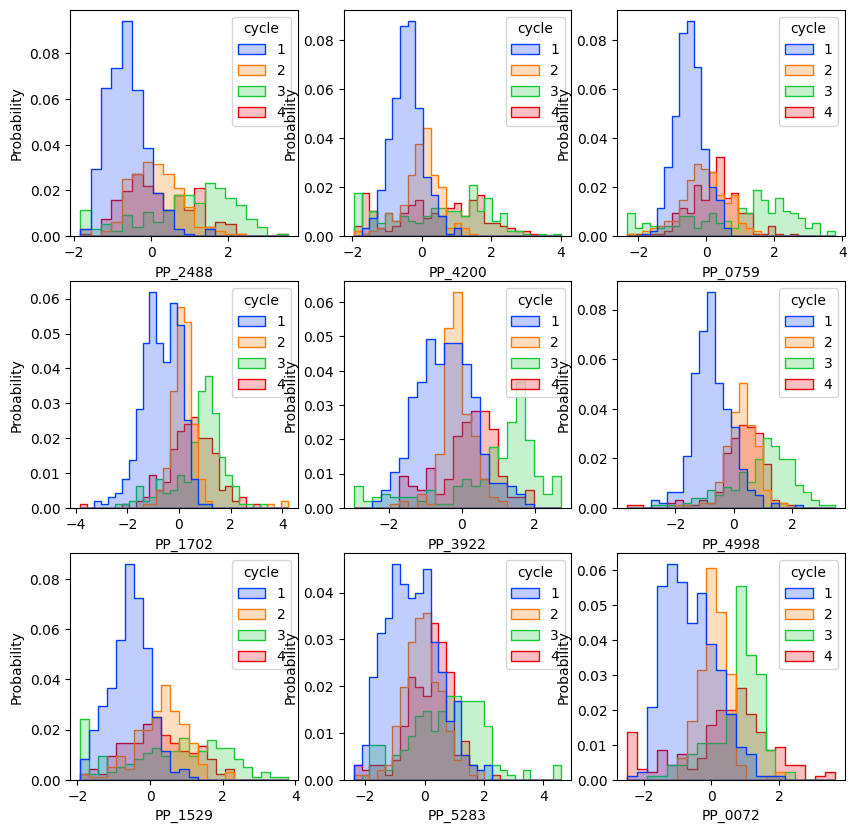

In [22]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize = (10,10))

for idx, axis in enumerate(fig.axes):
    sns.histplot(df_top10pcs, x = top_10_pc1.iloc[idx], hue = 'cycle', ax = axis, stat='probability', common_bins = True, element = 'step', palette='bright')

### Nonlinear dimensionality reduction


### LASSO
LASSO is a form of linear regression, which identifies models that look like this:

$titer = b_1 * P_1 + b_2 * P_2 + ... + b_n + P_n$

where the b values are coefficients to be learned and the P values are measured proteomics. 

LASSO uses regularization to identify sparse models. Regularization penalizes models with large coefficient values, which can prevent overfitting. Specifically, LASSO regularization favors models with parameters that are exactly zero, so it can be used to identify important features by looking at which small set of features is used to predict titer.

In [32]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_predict

Demonstration of lasso - create a regularized model and predict titer using cross validation.

Alpha = 0.01: There are 132 non-zero coefficients out of 1898 total coefficients.


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.467e-01, tolerance: 3.264e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.794e-01, tolerance: 2.919e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

Alpha = 0.0001: There are 922 non-zero coefficients out of 1898 total coefficients.


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.936e-01, tolerance: 3.929e-02
  model = cd_fast.enet_coordinate_descent(


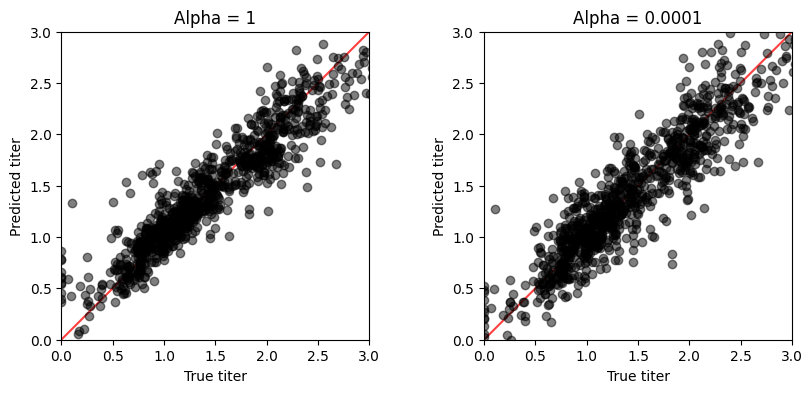

In [25]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))
alpha1 = 0.01
reg1 = Lasso(alpha = alpha1, max_iter = 10000)

y_pred = cross_val_predict(reg1, X_norm, y)
ax[0].scatter(y, y_pred, c = 'k', alpha = 0.5)
ax[0].set_xlabel('True titer')
ax[0].set_ylabel('Predicted titer')
ax[0].set_title(f'Alpha = {alpha1}')
reg1.fit(X_norm, y)
model_coefficients = reg1.coef_
print(f'Alpha = {alpha1}: There are {np.sum(np.abs(model_coefficients) > 0.0001)} non-zero coefficients out of {len(model_coefficients)} total coefficients.') 
lims = [0, 3]
# now plot both limits against eachother
ax[0].plot(lims, lims, 'r-', alpha=0.75, zorder=0)
ax[0].set_aspect('equal')
ax[0].set_xlim(lims)
ax[0].set_ylim(lims)

alpha2 = 0.0001
reg10 = Lasso(alpha = alpha2, max_iter = 10000)

y_pred = cross_val_predict(reg10, X_norm, y)
ax[1].scatter(y, y_pred, c = 'k', alpha = 0.5)
ax[1].set_xlabel('True titer')
ax[1].set_ylabel('Predicted titer')
ax[1].set_title(f'Alpha = {alpha2}')
reg10.fit(X_norm, y)
model_coefficients = reg10.coef_
ax[1].plot(lims, lims, 'r-', alpha=0.75, zorder=0)
ax[1].set_aspect('equal')
ax[1].set_xlim(lims)
ax[1].set_ylim(lims)

print(f'Alpha = {alpha2}: There are {np.sum(np.abs(model_coefficients) > 0.0001)} non-zero coefficients out of {len(model_coefficients)} total coefficients.') 



We can plot a range of alpha values and see that as regularization increases (alpha increases) the number of nonzero parameters decreases. We can also see that fewer parameters actually yields a better model (decreasing MAE), up to a point.

In [26]:
alpha_vec = np.linspace(0.1, 2, 20)
# alpha_vec = np.logspace(-6,-1, 2)
alpha_plot_vec = [1e-5, 1e-4, 1e-3, 1e-2]
alpha_vec = np.unique(np.sort(np.concatenate((alpha_vec, alpha_plot_vec))))
reg_all = []
y_pred_all = np.zeros([len(alpha_vec), len(y)])
mae = []
# plt.figure()
for idx, alpha in enumerate(alpha_vec):
    print(idx)
    # plt.subplot(4,5,idx+1)
    reg = Lasso(alpha = alpha, max_iter=10000)
    # reg = Lasso(alpha = alpha)

    reg.fit(X_norm,y)
    y_pred = cross_val_predict(reg, X_norm, y)
    reg_all.append(reg)
    y_pred_all[idx, :] = y_pred
    # plt.scatter(y, y_pred, s = 10)
    mae.append(1/len(y) * np.sum(np.abs(y-y_pred)))
mae = np.array(mae)

0


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.413e-01, tolerance: 3.929e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.887e-02, tolerance: 3.264e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

1


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.104e+00, tolerance: 3.929e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.467e-01, tolerance: 3.264e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


Text(0.5, 0, 'Alpha')

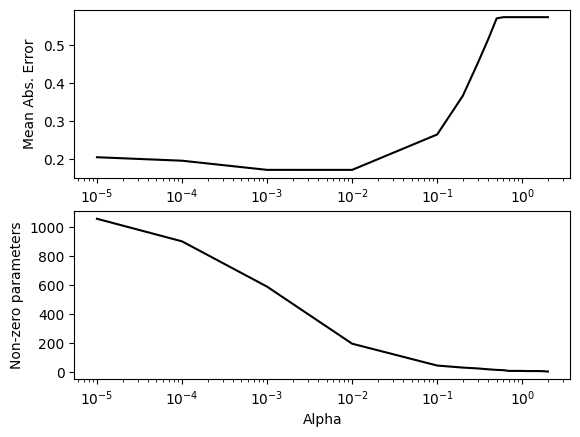

In [27]:
n_zero_params = np.array([np.sum(np.abs(r.coef_)<0.0001) for r in reg_all])
n_nonzero_params = np.array([np.sum(np.abs(r.coef_)>0.0001) for r in reg_all])
fig, ax = plt.subplots(nrows =2,ncols = 1)
ax[0].semilogx(alpha_vec, mae, 'k')
ax[1].semilogx(alpha_vec, n_nonzero_params, 'k')
ax[0].set_ylabel('Mean Abs. Error')
ax[1].set_ylabel('Non-zero parameters')
ax[1].set_xlabel('Alpha')

/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.887e-02, tolerance: 3.264e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.150e-02, tolerance: 2.919e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

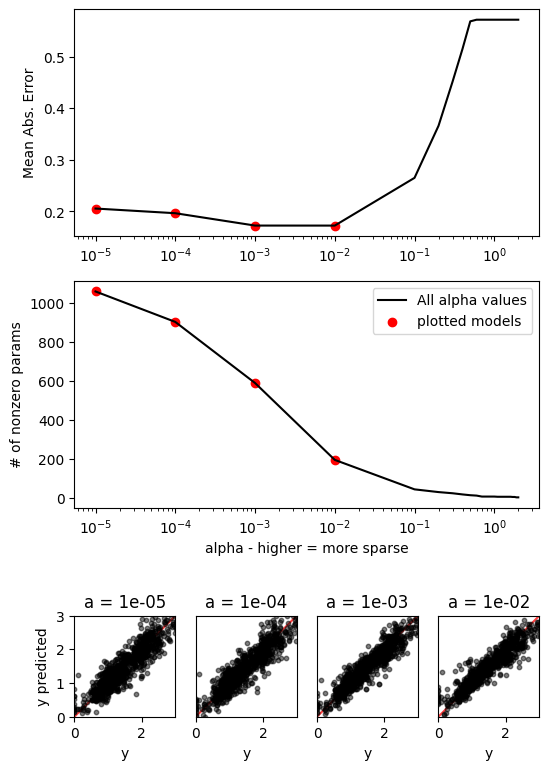

In [28]:
from matplotlib.gridspec import GridSpec

fig = plt.figure( figsize = (6,10))

gs = GridSpec(3, 4, figure=fig)
ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1,:])
ax_scatter = [fig.add_subplot(gs[2,i]) for i in [0,1,2,3]]

ax1.semilogx(alpha_vec, mae, 'k')
ax2.semilogx(alpha_vec, n_nonzero_params, 'k')

alpha_plot_indices = np.array([np.where(alpha_vec == ii)[0][0] for ii in alpha_plot_vec]).astype(int)
ax1.scatter(alpha_vec[alpha_plot_indices], mae[alpha_plot_indices], c = 'r')
ax2.scatter(alpha_vec[alpha_plot_indices], n_nonzero_params[alpha_plot_indices], c = 'r')

for ii, ax in enumerate(ax_scatter):
    reg = Lasso(alpha = alpha_plot_vec[ii], max_iter = 10000)

    y_pred = cross_val_predict(reg, X_norm, y)
    ax.scatter(y, y_pred, c='k', s = 10, alpha = 0.5)
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    lims = [0, 3]
    # now plot both limits against eachother
    ax.plot(lims, lims, 'r-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_title('a = {:.0e}'.format(alpha_plot_vec[ii]))
    ax.set_xlabel('y')
    if ii>0:
        ax.set_yticklabels([])
        ax.set_yticks([])
ax_scatter[0].set_ylabel('y predicted')
ax1.set_ylabel('Mean Abs. Error')
ax2.set_ylabel('# of nonzero params')
ax2.set_xlabel('alpha - higher = more sparse') 
ax2.legend(['All alpha values', 'plotted models'])
fig.savefig('./figures/LASSO_results.png')

We can also plot the coefficients for a specific alpha value. Here I'll use 10 (1e1), since it fits the data pretty well and doesn't have very many non-zero coefficients. 

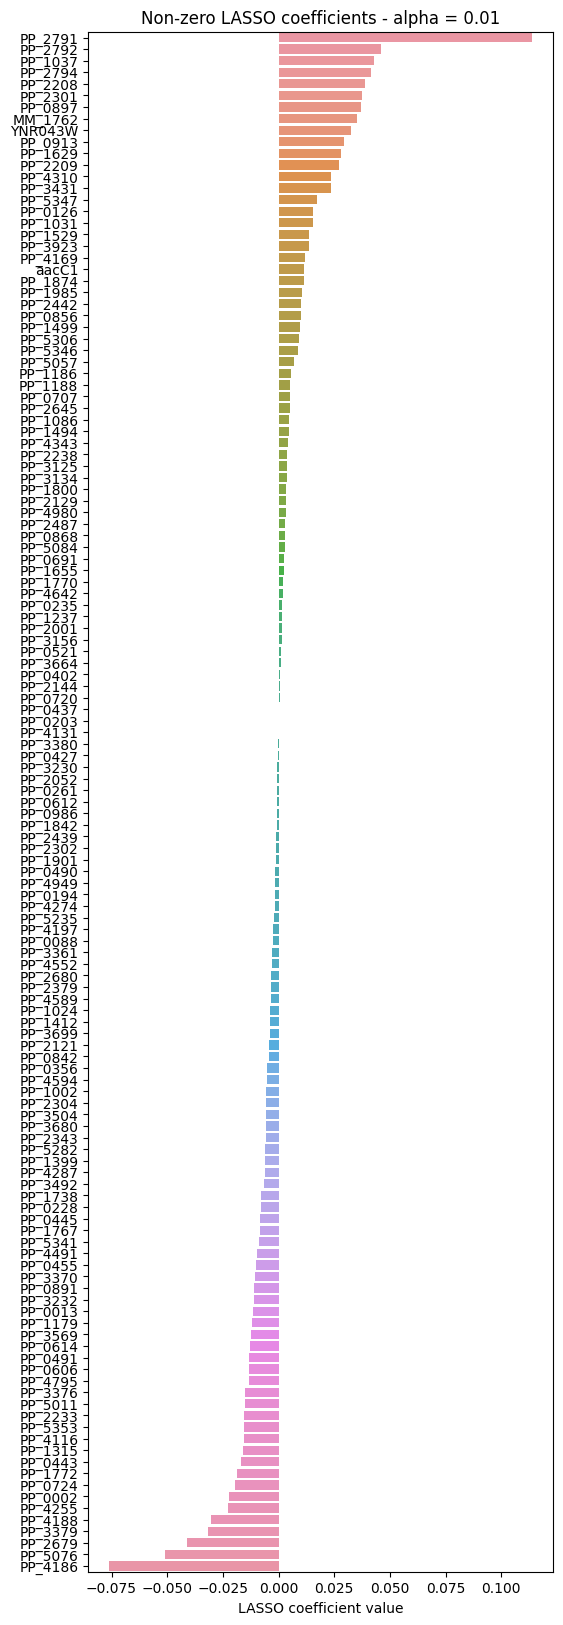

In [29]:
alpha_for_features = 1e-2
reg = Lasso(alpha = alpha_for_features)
reg.fit(X_norm, y)
coefficients = reg.coef_
coef_df = pd.DataFrame(data = coefficients, index = X_norm_df.columns, columns = ['coefficient'])

fig, ax = plt.subplots(figsize = (6,20))
sns.barplot(coef_df[coef_df['coefficient']!=0].sort_values('coefficient', ascending = False).T,
            orient = 'h', ax = ax)
ax.set_xlabel('LASSO coefficient value')
ax.set_title(f'Non-zero LASSO coefficients - alpha = {alpha_for_features}')

fig.savefig('./figures/LASSO_coefficients.png')

### Train model on round 1 and 2 to predict round 3

In [30]:
X_norm_c1c2 = X_norm[np.array(cycle_label) <= 2,:]
X_norm_c3 = X_norm[np.array(cycle_label) == 3,:]
X_norm_c4 = X_norm[np.array(cycle_label) == 4,:]

y_c1c2 = y[np.array(cycle_label) <= 2]
y_c3 = y[np.array(cycle_label) == 3]
y_c4 = y[np.array(cycle_label) == 4]
print(f"x_norm_c1c2 shape: {X_norm_c1c2.shape}\tx_norm_c3 shape: {X_norm_c3.shape}\tx_norm_c4 shape: {X_norm_c4.shape}")


x_norm_c1c2 shape: (579, 1898)	x_norm_c3 shape: (192, 1898)	x_norm_c4 shape: (183, 1898)


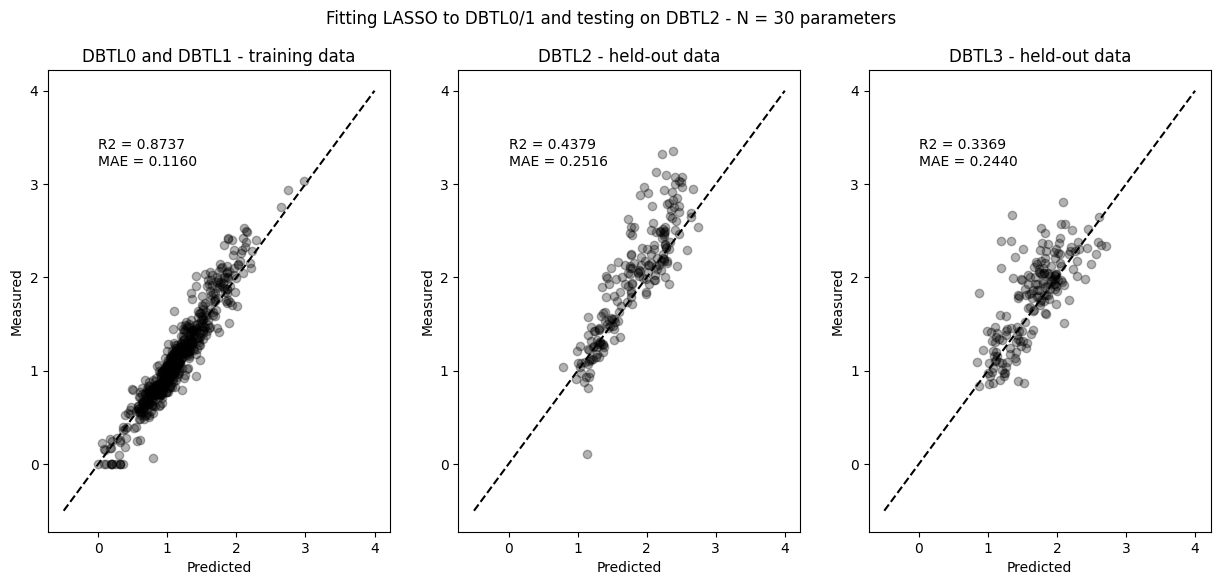

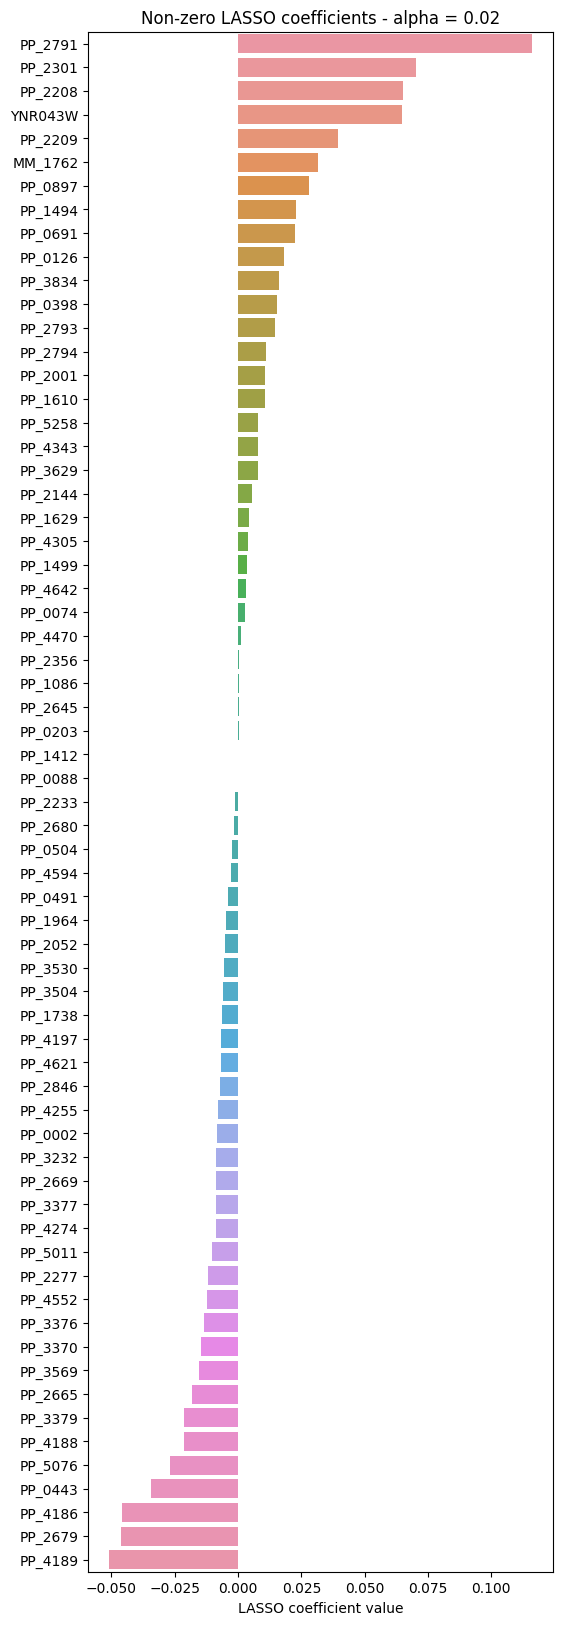

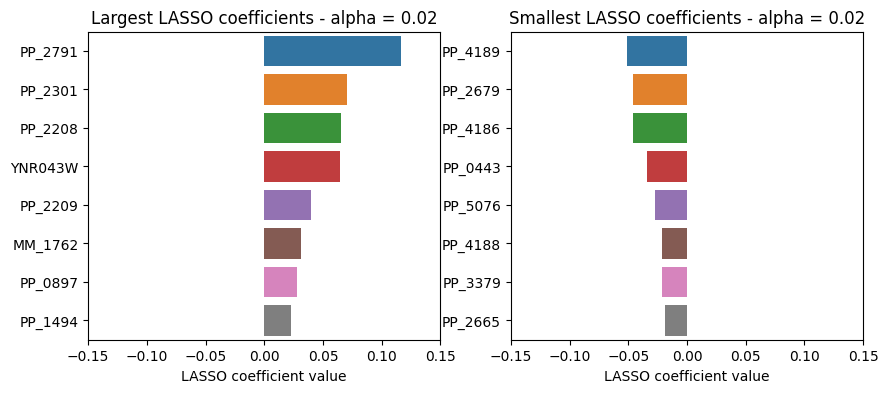

In [37]:
from sklearn.metrics import r2_score, mean_absolute_error

alpha = .02
reg = Lasso(alpha = alpha)
reg.fit(X_norm_c1c2, y_c1c2)
pred_c1c2 = reg.predict(X_norm_c1c2)
pred_c3 = reg.predict(X_norm_c3)
pred_c4 = reg.predict(X_norm_c4)
coef = reg.coef_
n_nonzero = sum(coef>0)

lims = [-.5, 4]
fig, ax = plt.subplots(nrows = 1, ncols =3, figsize = (15,6))
for i, data in enumerate([[pred_c1c2, y_c1c2],
                          [pred_c3, y_c3],
                          [pred_c4, y_c4]
                         ]):
    ax[i].scatter(data[0], data[1], color= 'k', alpha = 0.3)
    ax[i].plot(lims, lims, 'k--')
    # ax[i].set_xlim(lims)
    # ax[i].set_ylim(lims)
    ax[i].set_xlabel('Predicted')
    ax[i].set_ylabel('Measured')
    r2 = r2_score(data[0], data[1])
    mae = mean_absolute_error(data[0], data[1])
    ax[i].text(0, lims[1]*0.8,
               f"R2 = {r2:.4f}\nMAE = {mae:.4f}")

ax[0].set_title('DBTL0 and DBTL1 - training data')
ax[1].set_title('DBTL2 - held-out data')
ax[2].set_title('DBTL3 - held-out data')

plt.suptitle(f"Fitting LASSO to DBTL0/1 and testing on DBTL2 - N = {n_nonzero} parameters")
fig.savefig('./figures/LASSO_c0c1train_c2test.png')

coefficients = reg.coef_
coef_df = pd.DataFrame(data = coefficients, index = X_norm_df.columns, columns = ['coefficient'])
fig, ax = plt.subplots(figsize = (6,20))
sns.barplot(coef_df[coef_df['coefficient']!=0].sort_values('coefficient', ascending = False).T,
            orient = 'h', ax = ax)
ax.set_xlabel('LASSO coefficient value')
ax.set_title(f'Non-zero LASSO coefficients - alpha = {alpha}')
fig.savefig('./figures/LASSO_coefficients_DBTL2holdout.png')

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))
n_coef_plot = 8
sns.barplot(coef_df[coef_df['coefficient']!=0].sort_values('coefficient', ascending = False)[:n_coef_plot].T,
            orient = 'h', ax = ax[0])
sns.barplot(coef_df[coef_df['coefficient']!=0].sort_values('coefficient', ascending = True)[:n_coef_plot].T,
            orient = 'h', ax = ax[1])
ax[0].set_xlabel('LASSO coefficient value')
ax[1].set_xlabel('LASSO coefficient value')
ax[0].set_xlim([-0.15, 0.15])
ax[1].set_xlim([-0.15, 0.15])
ax[0].set_title(f'Largest LASSO coefficients - alpha = {alpha}')
ax[1].set_title(f'Smallest LASSO coefficients - alpha = {alpha}')

fig.savefig('./figures/LASSO_coefficients_DBTL2holdout_subset.png')

### Shapley analysis
Shapley analysis aims to identify the most important features for making accurate predictions. It does this by imagining that different subsets of features are different 'teams' playing against each other to win a 'game' by having the best prediction accuracy. By looking at which features are in the best performing 'team' (set of features) we can infer which features are required for good predictions. 

In [33]:
import xgboost
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [34]:
model_xgb = xgboost.XGBRegressor(n_estimators = 100, max_depth = 2).fit(X_norm_df,y)
X_subset = X_norm_df.iloc[:20,:]
explainer_xgb = shap.Explainer(model_xgb, X_subset)
shap_values_xgb = explainer_xgb(X_norm_df)
sample_ind = 20

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


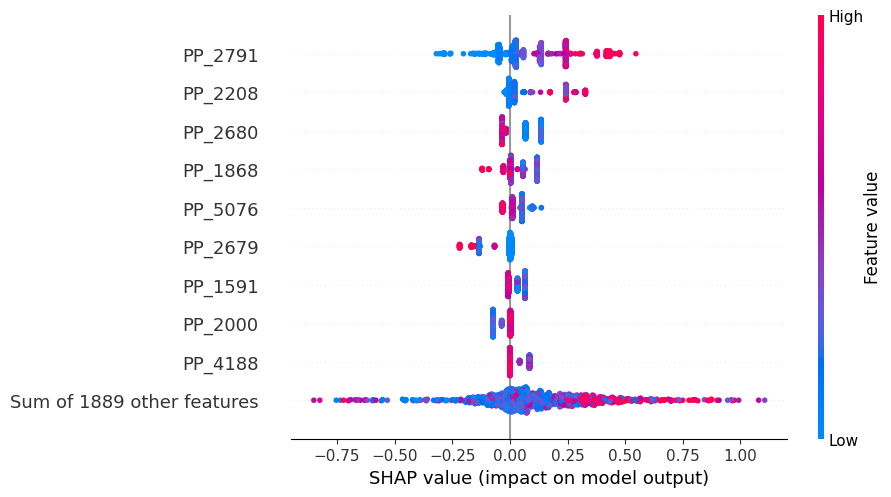

In [35]:
shap.plots.beeswarm(shap_values_xgb)


In [36]:
shap_ordering = np.mean(np.abs(shap_values_xgb.values), axis = 0)
shap_ordering.shape
shap_index = np.argsort(-shap_ordering)[:8]

In [35]:
shap_index

array([1102, 1364,  967, 1777, 1092,  892,  139,  182])

In [36]:
shap_ordering[shap_index]

array([0.10186089, 0.06094373, 0.05726962, 0.05336603, 0.04178684,
       0.04009671, 0.03122214, 0.03010041])

Text(0.5, 0.98, 'Highest shapley value features')

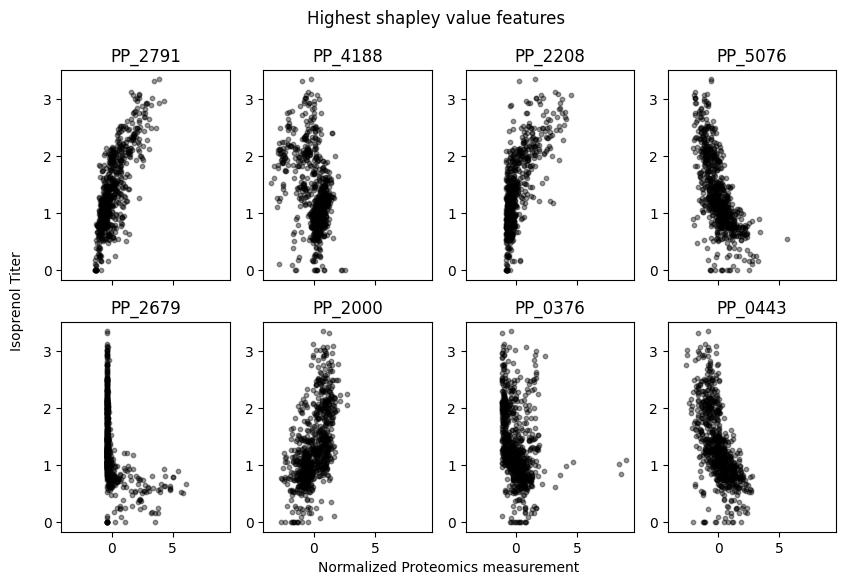

In [37]:
fig, ax = plt.subplots(2,4, figsize = (10,6), sharex=True, sharey =False)
for plot_idx, shap_idx in enumerate(shap_index):
    fig.axes[plot_idx].scatter(X_norm_df.iloc[:, shap_idx], y, s = 10, c = 'k', alpha = 0.4)
    fig.axes[plot_idx].set_title(X_norm_df.columns[shap_idx])
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Normalized Proteomics measurement")
plt.ylabel("Isoprenol Titer")   
plt.suptitle('Highest shapley value features')

In [38]:
shap_index_lowest = np.argsort(shap_ordering)[:8]
shap_ordering[shap_index_lowest]

array([0., 0., 0., 0., 0., 0., 0., 0.])

Text(0.5, 0.98, 'Lowest shapley value features - all zero')

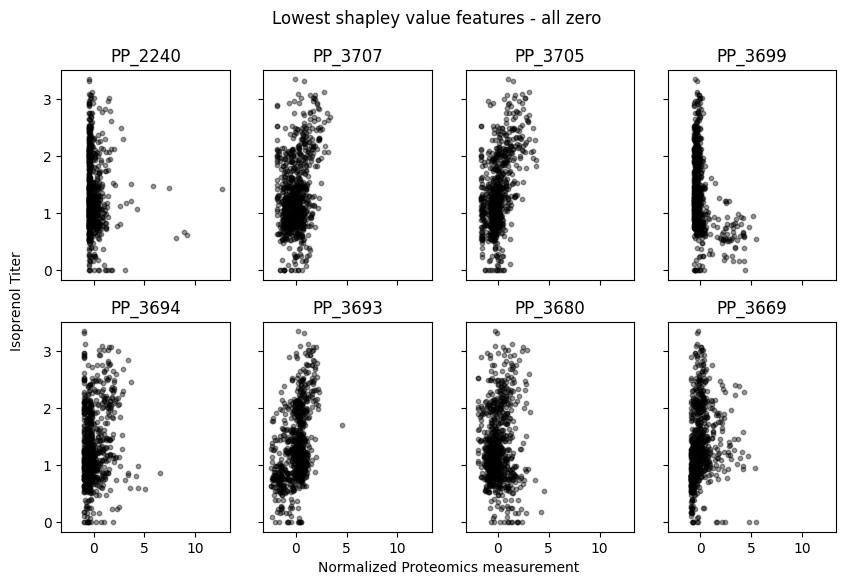

In [39]:
fig, ax = plt.subplots(2,4, figsize = (10,6), sharex=True, sharey =True)
for plot_idx, shap_idx in enumerate(shap_index_lowest):
    fig.axes[plot_idx].scatter(X_norm_df.iloc[:, shap_idx], y, s = 10, c = 'k', alpha = 0.4)
    fig.axes[plot_idx].set_title(X_norm_df.columns[shap_idx])
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Normalized Proteomics measurement")
plt.ylabel("Isoprenol Titer")   
plt.suptitle('Lowest shapley value features - all zero')

## LASSO for dCas9

In [36]:
# alpha_vec = np.linspace(0.1, 2, 20)
alpha_vec = np.logspace(-4,3, 25)
alpha_plot_vec = [1e-3, 1e-1, 1e1, 1e3]
alpha_vec = np.unique(np.sort(np.concatenate((alpha_vec, alpha_plot_vec))))
reg_all = []
y_pred_all = np.zeros([len(alpha_vec), len(y)])
mae = []
# plt.figure()
for idx, alpha in enumerate(alpha_vec):
    print(idx)
    # plt.subplot(4,5,idx+1)
    reg = Lasso(alpha = alpha, max_iter=10000)
    # reg = Lasso(alpha = alpha)

    reg.fit(X_dcas9_norm,y_dcas9)
    y_pred = cross_val_predict(reg, X_dcas9_norm, y_dcas9)
    reg_all.append(reg)
    y_pred_all[idx, :] = y_pred
    # plt.scatter(y, y_pred, s = 10)
    mae.append(1/len(y) * np.sum(np.abs(y-y_pred)))
mae = np.array(mae)

0


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.530e-01, tolerance: 2.311e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.292e-02, tolerance: 1.896e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

1


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.665e-01, tolerance: 2.311e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.982e-02, tolerance: 1.896e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

2


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.701e-01, tolerance: 2.311e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.734e-02, tolerance: 1.752e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

3


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.343e-01, tolerance: 2.311e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.809e-02, tolerance: 1.935e-02
  model = cd_fast.enet_coordinate_descent(


4


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.908e-02, tolerance: 2.311e-02
  model = cd_fast.enet_coordinate_descent(


5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


Text(0.5, 0, 'Alpha')

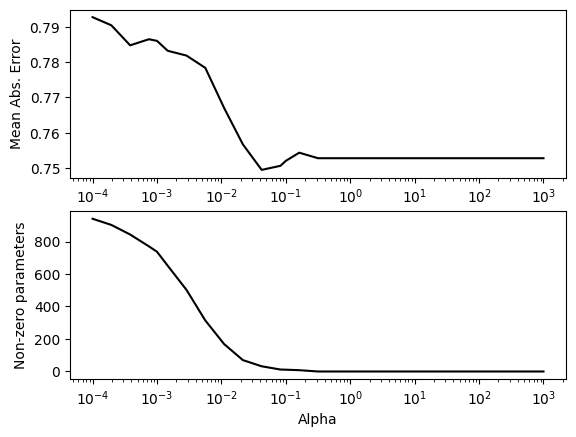

In [37]:
n_zero_params = np.array([np.sum(np.abs(r.coef_)<0.0001) for r in reg_all])
n_nonzero_params = np.array([np.sum(np.abs(r.coef_)>0.0001) for r in reg_all])
fig, ax = plt.subplots(nrows =2,ncols = 1)
ax[0].semilogx(alpha_vec, mae, 'k')
ax[1].semilogx(alpha_vec, n_nonzero_params, 'k')
ax[0].set_ylabel('Mean Abs. Error')
ax[1].set_ylabel('Non-zero parameters')
ax[1].set_xlabel('Alpha')

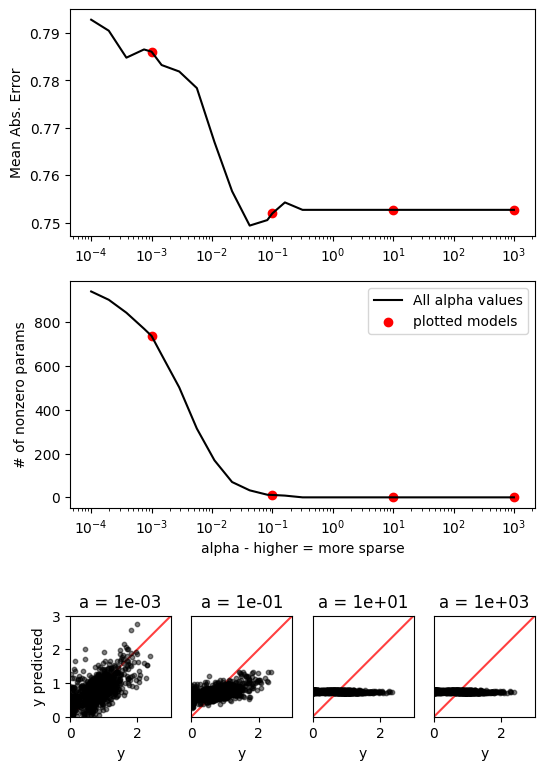

In [38]:
from matplotlib.gridspec import GridSpec

fig = plt.figure( figsize = (6,10))

gs = GridSpec(3, 4, figure=fig)
ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1,:])
ax_scatter = [fig.add_subplot(gs[2,i]) for i in [0,1,2,3]]

ax1.semilogx(alpha_vec, mae, 'k')
ax2.semilogx(alpha_vec, n_nonzero_params, 'k')

alpha_plot_indices = np.array([np.where(alpha_vec == ii)[0][0] for ii in alpha_plot_vec]).astype(int)
ax1.scatter(alpha_vec[alpha_plot_indices], mae[alpha_plot_indices], c = 'r')
ax2.scatter(alpha_vec[alpha_plot_indices], n_nonzero_params[alpha_plot_indices], c = 'r')

for ii, ax in enumerate(ax_scatter):
    reg = Lasso(alpha = alpha_plot_vec[ii], max_iter = 10000)

    y_pred = cross_val_predict(reg, X_dcas9_norm, y_dcas9)
    ax.scatter(y_dcas9, y_pred, c='k', s = 10, alpha = 0.5)
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    lims = [0, 3]
    # now plot both limits against eachother
    ax.plot(lims, lims, 'r-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_title('a = {:.0e}'.format(alpha_plot_vec[ii]))
    ax.set_xlabel('y')
    if ii>0:
        ax.set_yticklabels([])
        ax.set_yticks([])
ax_scatter[0].set_ylabel('y predicted')
ax1.set_ylabel('Mean Abs. Error')
ax2.set_ylabel('# of nonzero params')
ax2.set_xlabel('alpha - higher = more sparse') 
ax2.legend(['All alpha values', 'plotted models'])

Alpha = 0.001: There are 626 non-zero coefficients out of 1898 total coefficients.


(0.0, 3.0)

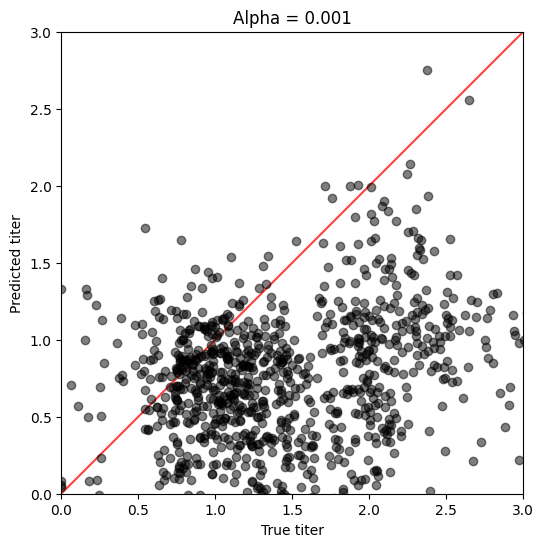

In [43]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6,6))
alpha1 = 1*10**-3
reg1 = Lasso(alpha = alpha1, max_iter = 10000)

y_pred = cross_val_predict(reg1, X_dcas9_norm, y_dcas9)
ax.scatter(y, y_pred, c = 'k', alpha = 0.5)
ax.set_xlabel('True titer')
ax.set_ylabel('Predicted titer')
ax.set_title(f'Alpha = {alpha1}')
reg1.fit(X_norm, y)
model_coefficients = reg1.coef_
print(f'Alpha = {alpha1}: There are {np.sum(np.abs(model_coefficients) > 0.0001)} non-zero coefficients out of {len(model_coefficients)} total coefficients.') 
lims = [0, 3]
# now plot both limits against eachother
ax.plot(lims, lims, 'r-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)